In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
import tensorflow.keras.losses as losses
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import concatenate

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import datetime
import calendar
from datetime import datetime
import numpy as np 
import pandas as pd

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
# import utils

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xcs224u/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
utils.fix_random_seeds()

In [6]:
train = pd.read_csv('./Corona_NLP_train.csv',encoding='latin1')
test = pd.read_csv('./Corona_NLP_test.csv',encoding='latin1')

train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
X = train['OriginalTweet'].copy()
y = train['Sentiment'].copy()

In [8]:
def data_cleaner(tweet):
    
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    
    # remove digits
    tweet = re.sub(r'\d+',' ', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)
    
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet)
    
    # removing stop words
    tweet = tweet.split()
    
#     tweet = " ".join([word for word in tweet if not word in stop_words])
    # lower case all words
    tweet = " ".join([word.lower() for word in tweet if not word in stop_words])
    
    return tweet


stop_words = stopwords.words('english')

X_cleaned = X.apply(data_cleaner)


X_cleaned.head()

0                                                     
1    advice talk neighbours family exchange phone n...
2    coronavirus australia: woolworths give elderly...
3    my food stock one empty... please, panic, ther...
4    me, ready go supermarket outbreak. not i'm par...
Name: OriginalTweet, dtype: object

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)

X = tokenizer.texts_to_sequences(X_cleaned)

vocab_size = len(tokenizer.word_index)+1

idx = 35866
print("Vocabulary size: {}".format(vocab_size))
print("\nExample:\n")
print("Sentence:\n{}".format(X_cleaned[idx]))
print("\nAfter tokenizing :\n{}".format(X[idx]))

X = pad_sequences(X, padding='post')
print("\nAfter padding :\n{}".format(X[idx]))

Vocabulary size: 36117

Example:

Sentence:
mdoc horhn ms ms brown mississippi prisoners are going on official food amp water strike april to protest the covid pandemic amp lack of prevententive measures taken by mdoc staff shortage inhumane living conditions poor food quality quality abuse amp demand msleg finalize amp enact sb

After tokenizing :
[18104, 33691, 9705, 9705, 3611, 12901, 8743, 199, 32, 197, 1552, 5, 9, 311, 3763, 377, 65, 6735, 10, 1, 15, 9, 1058, 386, 33692, 324, 577, 818, 18104, 71, 380, 8120, 695, 1322, 736, 5, 1294, 1294, 2483, 9, 24, 33693, 33694, 9, 5494, 13176]

After padding :
[18104 33691  9705  9705  3611 12901  8743   199    32   197  1552     5
     9   311  3763   377    65  6735    10     1    15     9  1058   386
 33692   324   577   818 18104    71   380  8120   695  1322   736     5
  1294  1294  2483     9    24 33693 33694     9  5494 13176     0     0
     0     0     0     0     0     0]


In [10]:
encoding = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }

labels = ['Negative', 'Neutral', 'Positive']


y.replace(encoding, inplace=True)

In [11]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.4):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    



In [24]:
embed_dim = 16  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
maxlen = X.shape[-1]
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
# x = layers.Dropout(0.4)(x)
# x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [25]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',metrics=['accuracy']
             )
logdir = "logs/att_scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
history = model.fit(X, y, 
                    callbacks=[tensorboard_callback],
                    epochs=10, validation_split=0.12, batch_size=32)


Epoch 1/10
1132/1132 [==============================] - 25s 23ms/step - loss: 0.8894 - accuracy: 0.6491 - val_loss: 0.7572 - val_accuracy: 0.7874
Epoch 2/10
1132/1132 [==============================] - 27s 24ms/step - loss: 0.7020 - accuracy: 0.8493 - val_loss: 0.6993 - val_accuracy: 0.8494
Epoch 3/10
1132/1132 [==============================] - 27s 24ms/step - loss: 0.6590 - accuracy: 0.8922 - val_loss: 0.6867 - val_accuracy: 0.8623
Epoch 4/10
1132/1132 [==============================] - 27s 24ms/step - loss: 0.6417 - accuracy: 0.9094 - val_loss: 0.6843 - val_accuracy: 0.8654
Epoch 5/10
1132/1132 [==============================] - 27s 24ms/step - loss: 0.6314 - accuracy: 0.9199 - val_loss: 0.6824 - val_accuracy: 0.8666
Epoch 6/10
1132/1132 [==============================] - 27s 24ms/step - loss: 0.6243 - accuracy: 0.9268 - val_loss: 0.6834 - val_accuracy: 0.8650
Epoch 7/10
1132/1132 [==============================] - 27s 24ms/step - loss: 0.6207 - accuracy: 0.9310 - val_loss: 0.6856 -

# Evaluation

In [19]:
X_test = test['OriginalTweet'].copy()
y_test = test['Sentiment'].copy()

X_test = X_test.apply(data_cleaner)

X_test = tokenizer.texts_to_sequences(X_test)

X_test = pad_sequences(X_test, padding='post')

# X_test_day = test['TweetAt'].apply(findDay)
y_test.replace(encoding, inplace=True)

In [20]:
# loss, acc = model.evaluate([X_test, X_test_day],y_test,verbose=0)
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.7122766971588135
Test Accuracy: 0.8385992646217346


In [21]:
pred = np.argmax(model.predict(X_test), axis=1)

In [22]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = preds.flatten()
    labels_flat = labels.tolist()
    return f1_score(labels_flat, preds_flat, average='weighted')

f1_score_func(pred, y_test)

0.8385250898251286

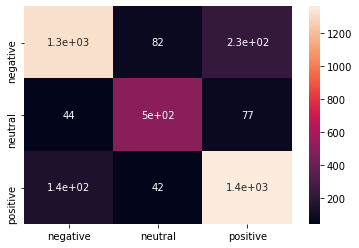

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_mat = confusion_matrix(y_true = y_test, y_pred = pred)
sns.heatmap(confusion_mat, annot=True, 
            xticklabels=['negative','neutral','positive'],
            yticklabels=['negative','neutral','positive'])